In [42]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22-year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [43]:
doc = nlp("Nagal won the first set.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [20]:
from IPython.display import clear_output

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [5]:
candidate_sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [6]:
candidate_sentences['sentence'].sample(5)

1684                      parallel cinema films, in and outside bollywood, tended to be less popular at the box office.
3288                                                                                 but, it feels like the right time.
1707                                              indian movies permitted a new youth culture without becoming western.
661                                               any computer-graphic visual effects are digitally added by an artist.
700     first was the involvement of actor and utah resident robert redford, who became the festival's inaugural chair.
Name: sentence, dtype: object

In [48]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    
    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            #############################################################

    return [ent1.strip(), ent2.strip()]

In [49]:
get_entities("Follow up with AWS credits guy")

['', 'AWS credits guy']

In [50]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [51]:
get_relation("Follow up with AWS credits guy")

'Follow'

In [18]:
tqdm(candidate_sentences["sentence"])

  0%|          | 0/4318 [00:00<?, ?it/s]

  0%|          | 0/4318 [00:00<?, ?it/s]

In [52]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))
    clear_output(wait=True)


100%|██████████| 4318/4318 [00:31<00:00, 136.48it/s]

In [53]:
relations = []

for i in tqdm(candidate_sentences["sentence"]):
    relations.append(get_relation(i))
    clear_output(wait=True)


100%|██████████| 4318/4318 [00:30<00:00, 141.89it/s]

In [54]:
pd.Series(relations).value_counts()[0:20]

is             371
was            297
released on     92
are             74
include         73
were            65
released        40
composed by     35
's              34
have            31
became          30
has             30
become          28
released in     27
included        26
produced        22
called          22
been            21
considered      20
had             20
dtype: int64

In [55]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

In [56]:
df_kg = pd.DataFrame({"source":source,"target":target,"edge":relations})

In [57]:
df_kg.head()

,source,target,edge
0,connie,own,decides
1,later woman,’s distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


In [58]:
KG = nx.from_pandas_edgelist(df_kg,source="source",target="target",edge_attr=True,create_using=nx.MultiDiGraph())

In [59]:
def getKnowledgeGraphForRelation(df_kg, relation):
    return nx.from_pandas_edgelist(df_kg[df_kg['edge']==relation], source="source",target="target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [60]:
def plotKnowledgeGraph(KG,distance_between_nodes=0.5):
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(KG, k = distance_between_nodes) # k regulates the distance between nodes
    nx.draw(KG, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

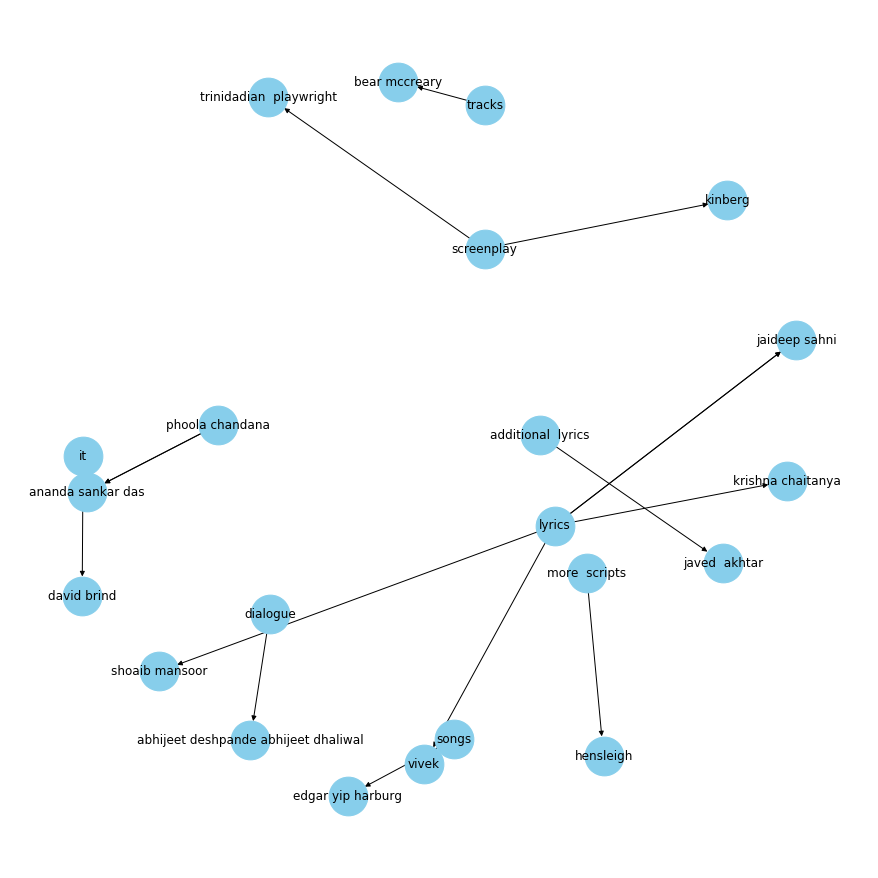

In [61]:
relation = "written by"
KG = getKnowledgeGraphForRelation(df_kg,relation)
plotKnowledgeGraph(KG)